In [93]:
import os
import shutil
import glob
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

tf.__version__

'2.5.0'

# Preprocess data

## Split data

In [2]:
should_prepare_data = False

train_sequential = False

train_residual = False

In [3]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [4]:
if should_prepare_data:
    prepare_data()

## Count images of each class and display chart

In [5]:
def get_count_of_images(split_folders):
    
    '''
    Counts number of files in every class in train/validation/test sets.
    
    Arguments:
    split_folders --- path to train/val/test which must contain folders of each class
                      e.g. './data/train'
    '''
    
    dict_count = {}
     
    for dir_path in split_folders:
    
        dir_name = os.path.basename(os.path.normpath(dir_path))
        dict_count[dir_name] = {}
    
        for root, dirs, files in os.walk(dir_path):

            if len(files) > 0:

                class_name = os.path.basename(os.path.normpath(root))
                count = len(files)

                dict_count[dir_name][class_name] = count
                
    return dict_count

In [6]:
split_folders = ['./data/output_flowers/train', './data/output_flowers/val', './data/output_flowers/test']

data = get_count_of_images(split_folders)

In [7]:
df = pd.DataFrame(data)
df['total']= df.sum(axis=1)
df

,train,val,test,total
tulip,688,147,149,984
rose,548,117,119,784
dandelion,736,157,159,1052
sunflower,513,109,111,733
daisy,534,114,116,764


In [8]:
def display_graph_of_images_count(dataframe):
    ax = dataframe.plot(kind='bar', figsize=(12, 8), title='Images count per class',
                        xlabel='Class', ylabel='Count', legend=False, fontsize=12)
    
    ax.legend(fontsize=12)

    for i in range(len(dataframe.columns)):
        ax.bar_label(ax.containers[i], label_type='edge', rotation=90, fontsize=12, padding=3)

    ax.margins(y=0.1)

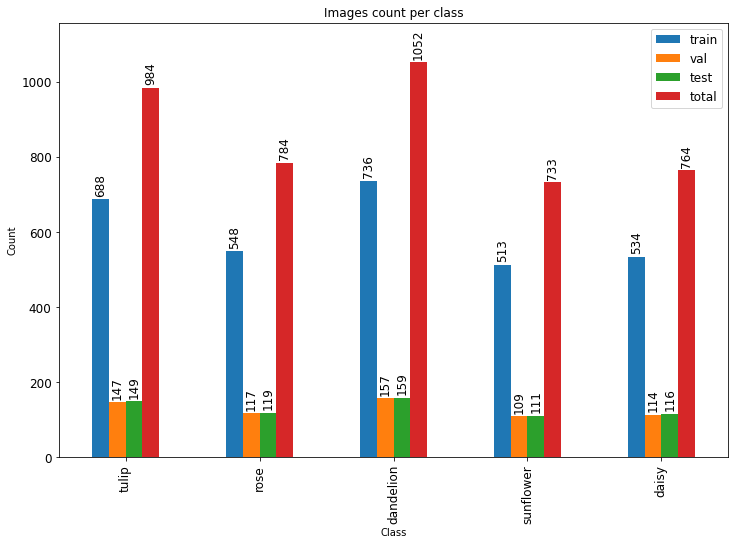

In [9]:
display_graph_of_images_count(df)

# Define train/val/test sets

In [10]:
batch_size = 32
img_height = 240
img_width = 240

train_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )

Found 3019 files belonging to 5 classes.


In [12]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [14]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

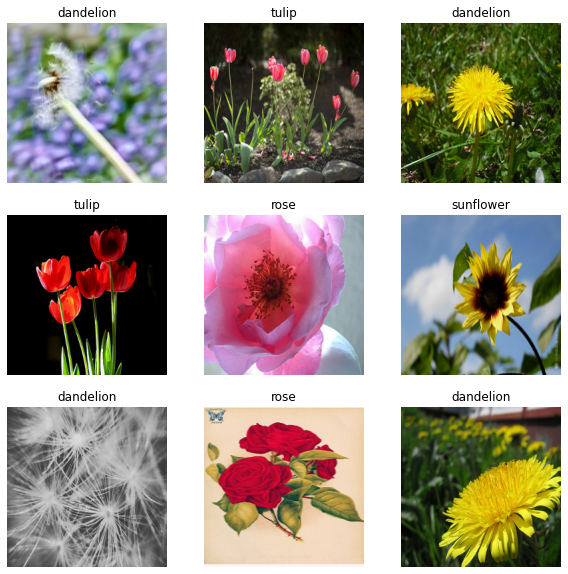

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Data augmentation

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.


# Deep learning models

## Sequential

In [17]:
def get_model(num_classes, dropout_rate=0.5):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),          

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes)  
    ])
    
    return model

In [18]:
model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 240, 240, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 240, 240, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0

In [19]:
# Callbacks

def best_val_acc_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    return checkpoint_callback


In [20]:
epochs = 50

checkpoint_path = './saved_weights/flowers_sequential_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_sequential:
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[best_val_acc]
    )

In [21]:
if train_sequential:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 3))
    plt.show()

In [22]:
model.load_weights('./saved_weights/flowers_sequential_model')

In [36]:
model.evaluate(test_ds)

21/21 [==============================] - 1s 17ms/step - loss: 0.6444 - accuracy: 0.8012


[0.6444306373596191, 0.8012232184410095]

## Residual 

In [24]:
def conv2d_block(input_tensor, n_filters):
    
    x = input_tensor
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    return x
    

In [25]:
def residual_block(input_tensor, n_filters):
    
    block_1 = conv2d_block(input_tensor, n_filters=n_filters)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(block_1)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.add([block_1, x])
    
    return x

In [26]:
def get_res_model(num_classes, filters_conv2d_blocks):
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    for num_filters in filters_conv2d_blocks:
        x = residual_block(input_tensor=x, n_filters=num_filters)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="residual_model")
    
    return model

In [27]:
model_res = get_res_model(5, [32, 64, 64, 64, 128])
model_res.summary()

Model: "residual_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 240, 240, 32) 896         rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 240, 240, 32) 9248        conv2d_5[0][0]                   
_____________________________________________________________________________________

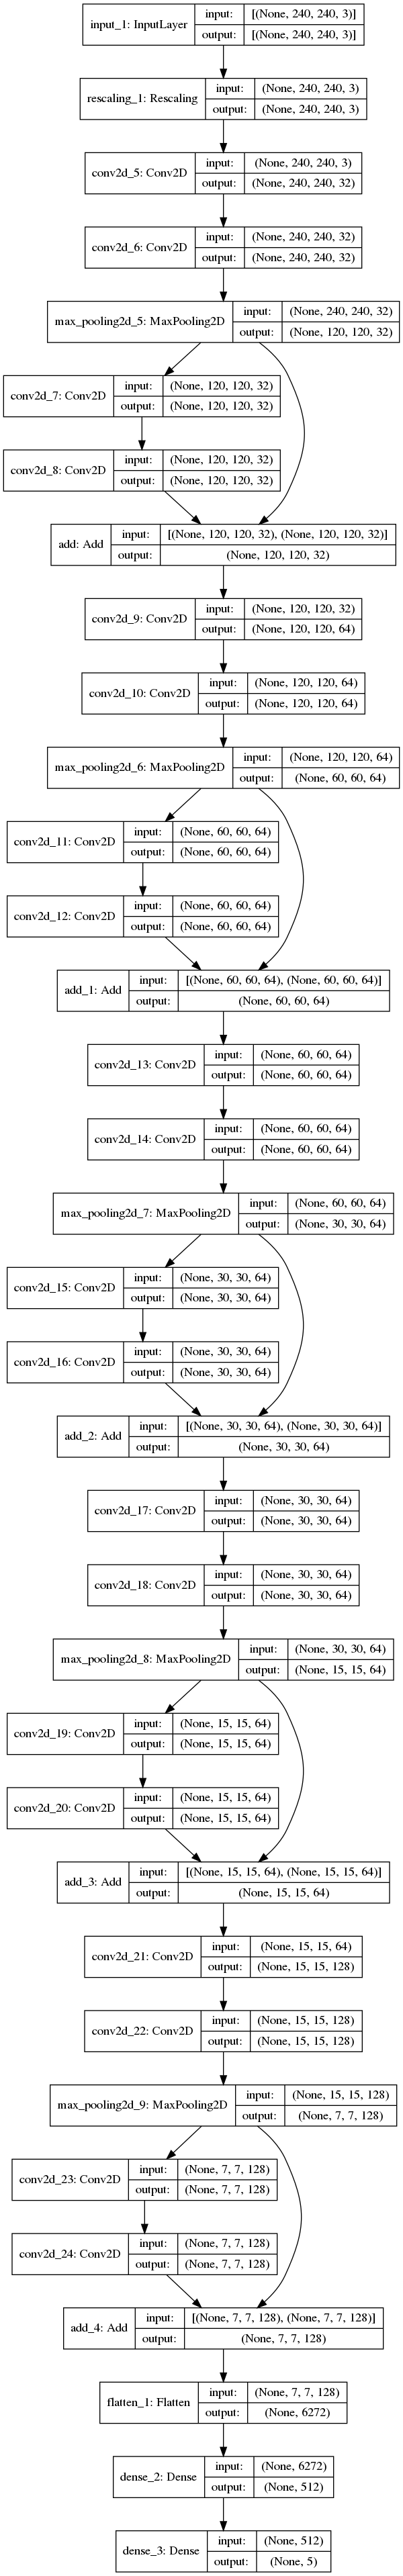

In [28]:
tf.keras.utils.plot_model(model_res, "res_model.png", show_shapes=True)


In [29]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs = 50

checkpoint_path = './saved_weights/flowers_residual_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_residual:
    
    history_res = model_res.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=[best_val_acc]
    )

In [31]:
def display_plots(history_var):
    acc = history_var.history['accuracy']
    val_acc = history_var.history['val_accuracy']

    loss = history_var.history['loss']
    val_loss = history_var.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 2))
    plt.show()
    
    
if train_residual:
    display_plots(history_res)

In [32]:
model_res.load_weights('./saved_weights/flowers_residual_model')

In [33]:
model_res.evaluate(test_ds)

21/21 [==============================] - 7s 68ms/step - loss: 0.7301 - accuracy: 0.7875


[0.7301133871078491, 0.7874617576599121]

## Model evaluation

In [110]:
# ! pip install pretty-confusion-matrix

In [111]:
from sklearn.metrics import classification_report
from pretty_confusion_matrix import pp_matrix

In [113]:
def display_heatmap_for_classification(path_to_test_dir, predicitve_model):
    
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        path_to_test_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(img_height,img_width),
        batch_size=batch_size)

    predictions = np.array([])
    
    labels =  np.array([])

    for x, y in test_data:

        predictions = np.concatenate([predictions, np.argmax(predicitve_model.predict(x), axis=-1)])
        
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

    matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_matrix = pd.DataFrame(matrix, index = [i for i in test_data.class_names],
                      columns = [i for i in test_data.class_names])

    pp_matrix(df_matrix)

Found 654 files belonging to 5 classes.


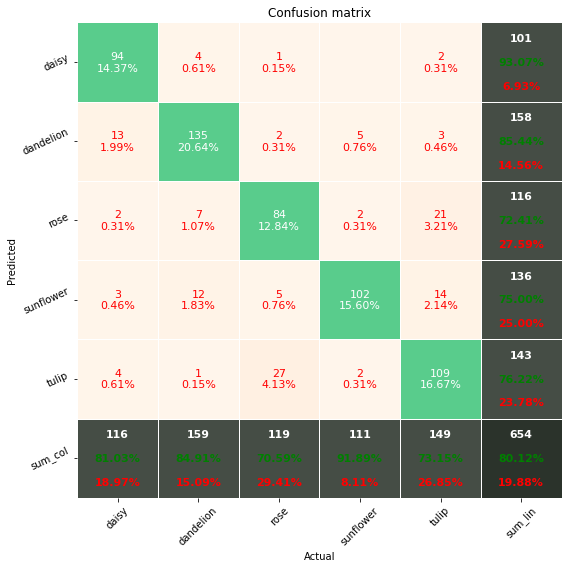

In [115]:
display_heatmap_for_classification(path_to_test_dir=test_dir, predicitve_model=model)